In [3]:
import pandas as pd
import os
import opendatasets as od
from tqdm import tqdm
from pathlib import Path
import shutil
import random
from coulumb_utils.xyz import read_xyz, parse_xyz_file, create_dataframe_from_xyz
from coulumb_utils.calculate_coulumb_matrix import calculate_coulomb_matrix
from coulumb_utils.sort_molecules import sort_by_atomic_number, sort_by_row_norm
from coulumb_utils.normalize import normalize_min_max, log_normalize
from coulumb_utils.eigen_padd import compute_eigenvalues, padd_eig, padd_matrix
from coulumb_utils.standardize import standardize_matrix
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.ticker import MaxNLocator,ScalarFormatter
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from sklearn.linear_model import Ridge
from xgboost import plot_importance

# Download dataset

The dataset is on Kaggle - https://www.kaggle.com/datasets/mariovozza5/qm9-molecules

In [4]:

dataset = "https://www.kaggle.com/datasets/mariovozza5/qm9-molecules"

if not os.path.exists("qm9-molecules"): od.download(dataset)

# Load xyz files

In [5]:
work_path = Path("./qm9-molecules/")
data_path = work_path.joinpath("data")

subset_size = 1000

df = create_dataframe_from_xyz(data_path, subset_size)
df_sorted = df.sort_values('index', ascending=True)

df_sorted.head(10)

100%|██████████| 1000/1000 [00:00<00:00, 30791.57it/s]


,filename,n_atoms,index,A,B,C,mu,alpha,homo,lumo,gap,R2,zpve,U0,U,H,G,Cv
999,qm9_12,6,12,73.84720,11.34793,9.83639,3.7286,21.57,-0.2543,0.0302,0.2845,145.3078,0.045279,-169.860788,-169.856903,-169.855958,-169.885594,10.890
135,qm9_162,13,162,9.13872,6.09542,4.76786,0.2527,48.92,-0.2519,0.0987,0.3506,350.7167,0.116089,-195.179738,-195.175335,-195.174391,-195.206606,16.868
649,qm9_325,7,325,8.71899,2.49294,1.93864,1.4415,38.68,-0.2978,-0.1503,0.1475,551.5682,0.035739,-320.029854,-320.024005,-320.023061,-320.059734,18.042
438,qm9_402,12,402,6.03973,3.14206,2.43199,1.7508,52.23,-0.2616,0.0263,0.2879,548.2216,0.094019,-269.176124,-269.169791,-269.168847,-269.205558,22.957
370,qm9_574,13,574,10.97625,1.97735,1.80890,4.0027,53.78,-0.3029,0.0346,0.3375,669.5084,0.108659,-249.358446,-249.352356,-249.351412,-249.388285,21.499
157,qm9_644,14,644,7.69236,3.03473,2.71562,1.8101,53.28,-0.2579,0.0764,0.3343,531.2446,0.120036,-270.399529,-270.393975,-270.393031,-270.428396,20.831
252,qm9_655,14,655,5.08056,4.85085,2.70226,1.1836,54.57,-0.2427,0.0243,0.2671,504.8171,0.121790,-270.435807,-270.430526,-270.429581,-270.464270,19.969
591,qm9_973,14,973,3.70058,3.25290,1.74999,0.8011,59.47,-0.1768,0.0585,0.2353,694.6721,0.113634,-324.613156,-324.605898,-324.604954,-324.644885,25.999
156,qm9_1107,19,1107,3.14334,2.26158,1.89442,1.6833,63.11,-0.2613,0.0648,0.3261,803.2300,0.168225,-348.061993,-348.052811,-348.051867,-348.094469,34.301
291,qm9_1119,12,1119,5.89401,1.77448,1.42578,5.8161,48.57,-0.2545,0.0149,0.2695,798.2635,0.090779,-393.905418,-393.898035,-393.897091,-393.937268,26.151


# Data exploration

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  1000 non-null   object 
 1   n_atoms   1000 non-null   int64  
 2   index     1000 non-null   int64  
 3   A         1000 non-null   float64
 4   B         1000 non-null   float64
 5   C         1000 non-null   float64
 6   mu        1000 non-null   float64
 7   alpha     1000 non-null   float64
 8   homo      1000 non-null   float64
 9   lumo      1000 non-null   float64
 10  gap       1000 non-null   float64
 11  R2        1000 non-null   float64
 12  zpve      1000 non-null   float64
 13  U0        1000 non-null   float64
 14  U         1000 non-null   float64
 15  H         1000 non-null   float64
 16  G         1000 non-null   float64
 17  Cv        1000 non-null   float64
dtypes: float64(15), int64(2), object(1)
memory usage: 140.8+ KB


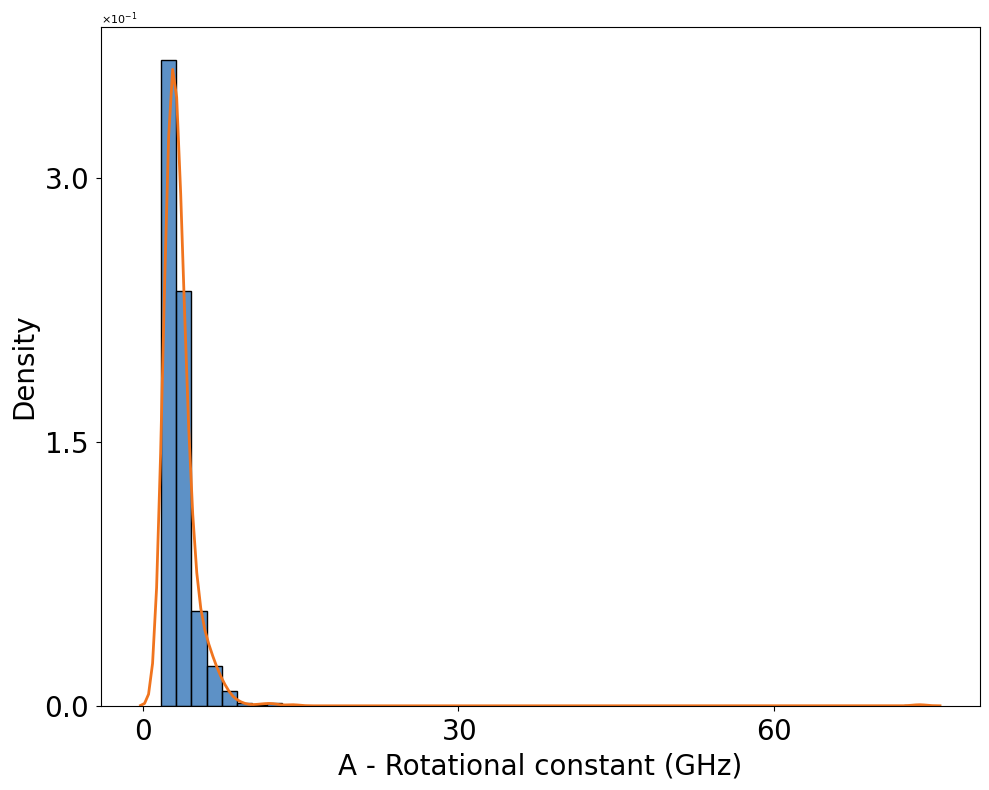

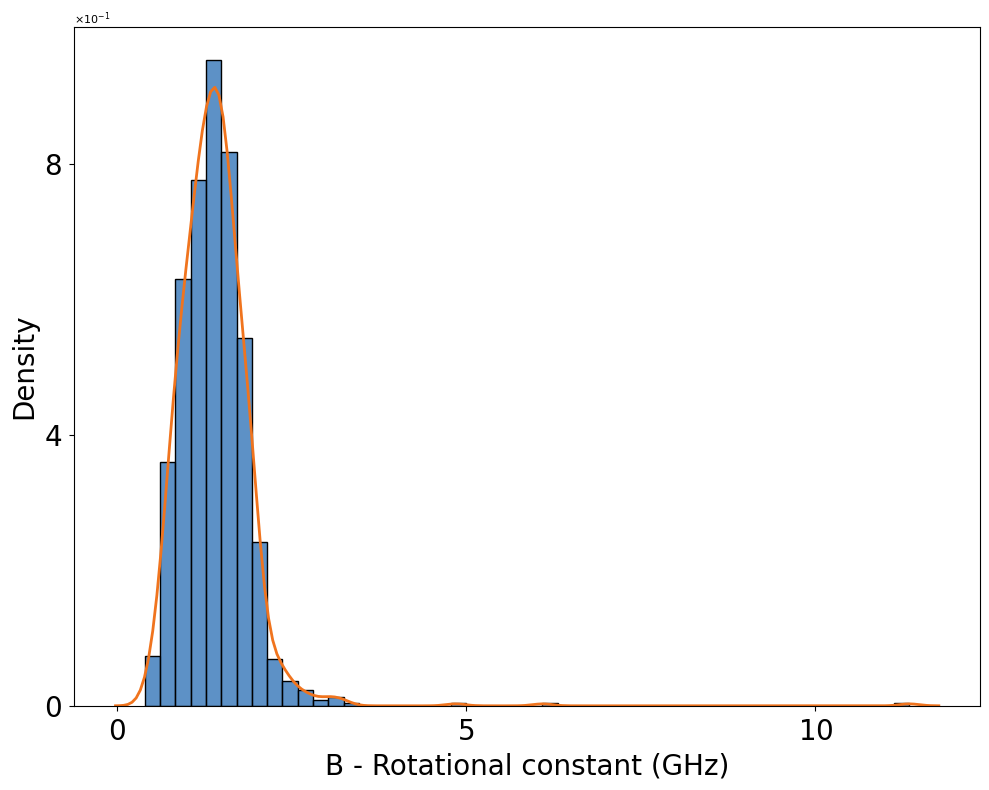

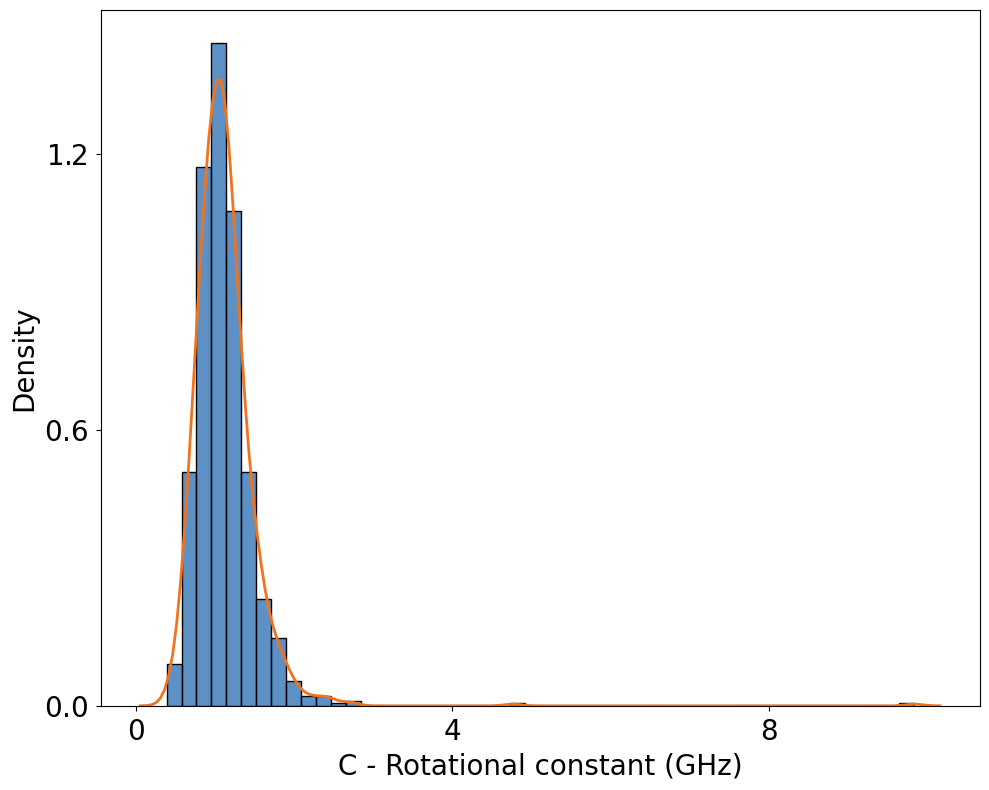

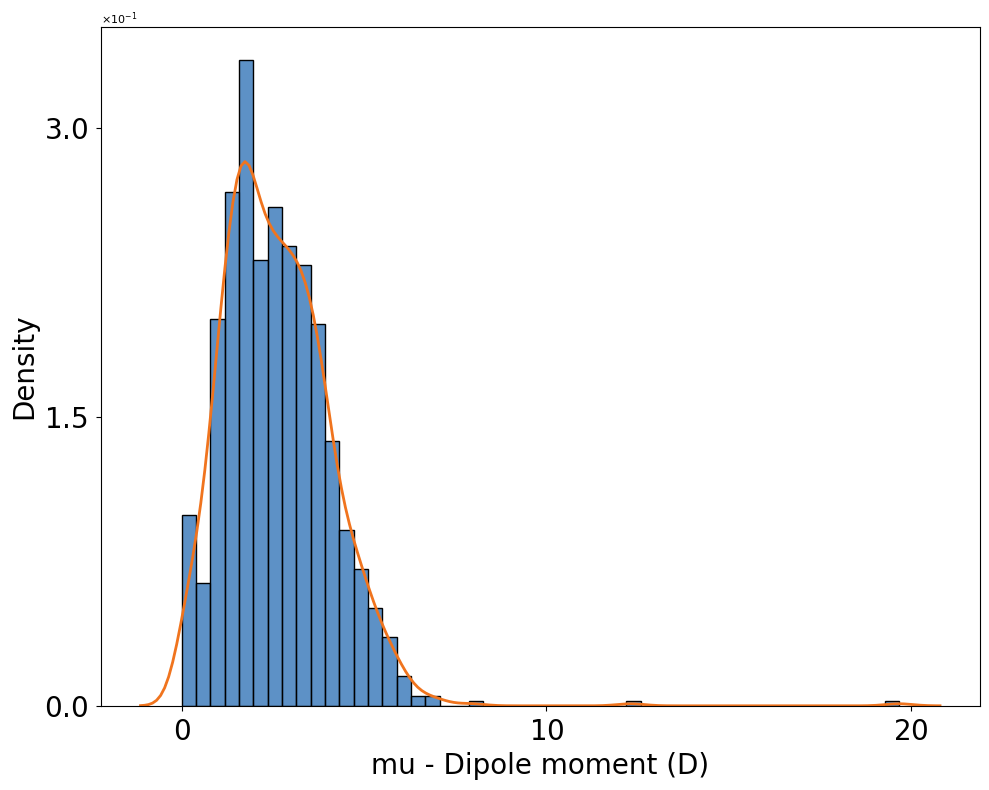

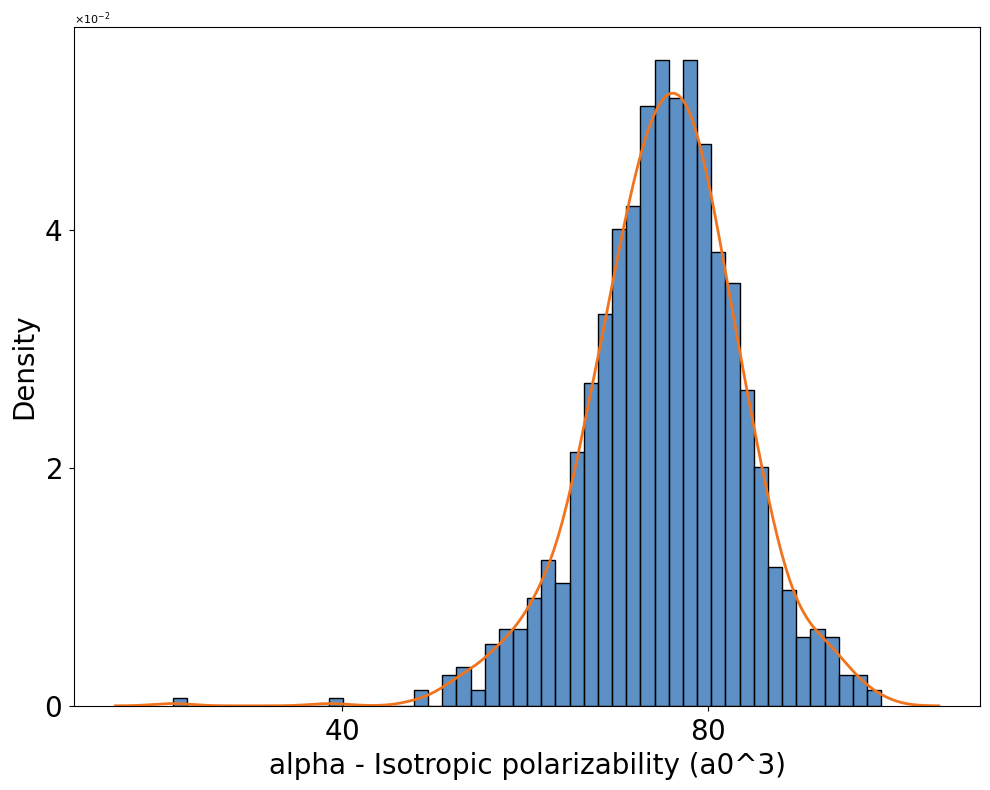

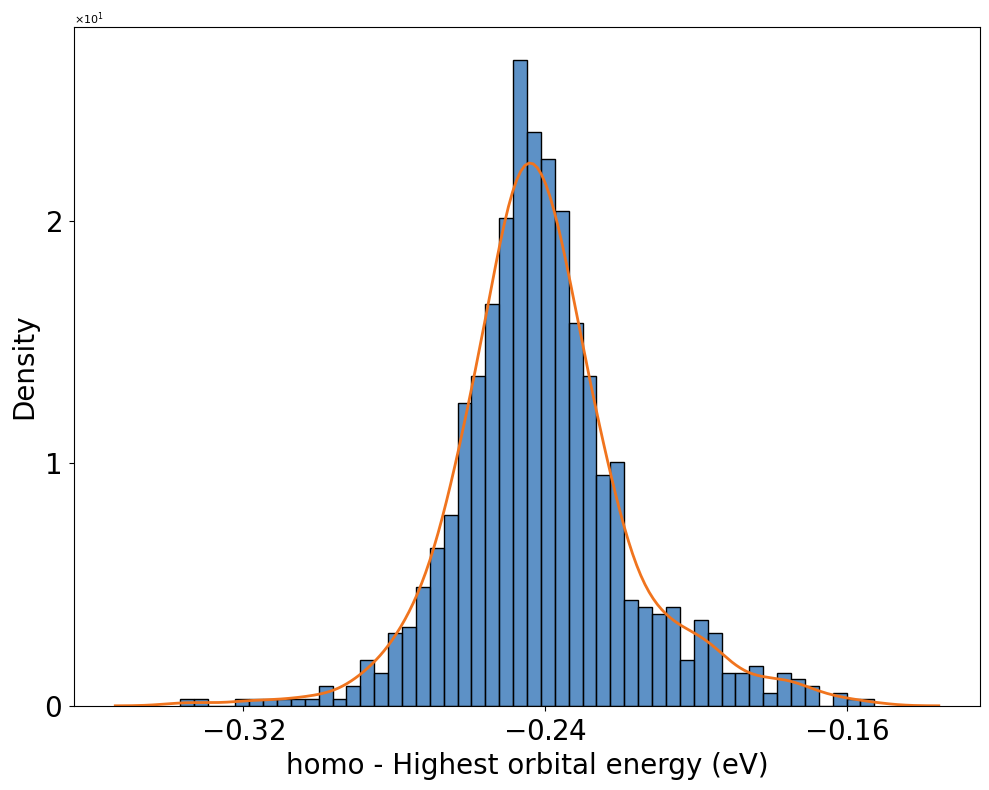

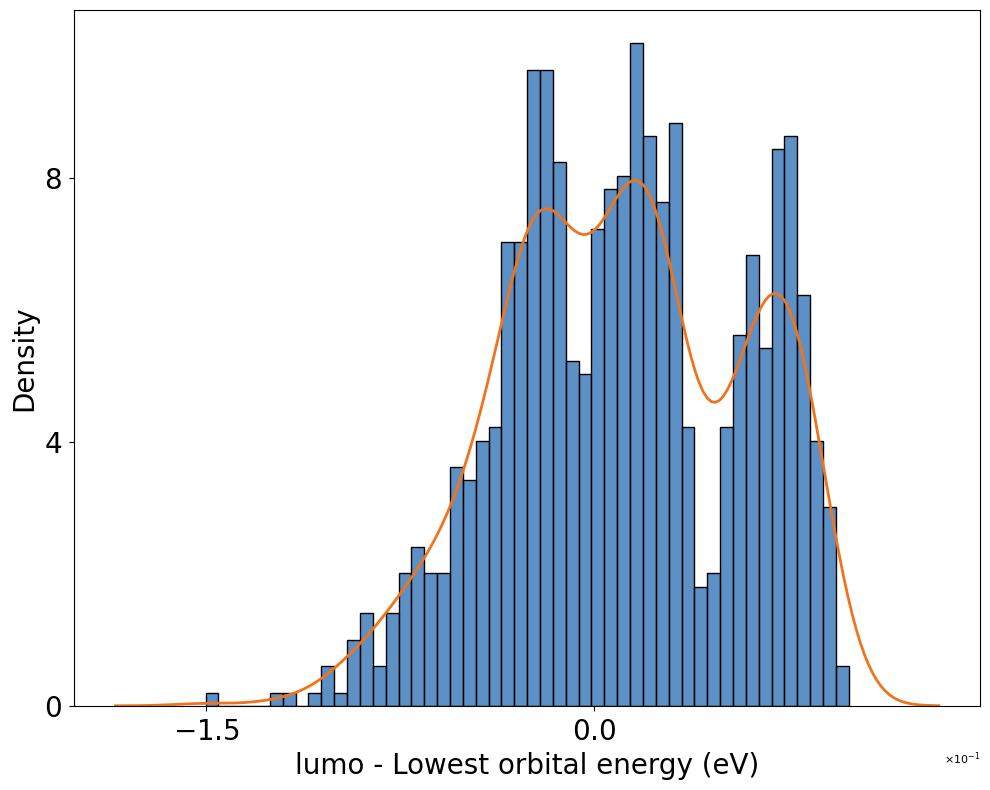

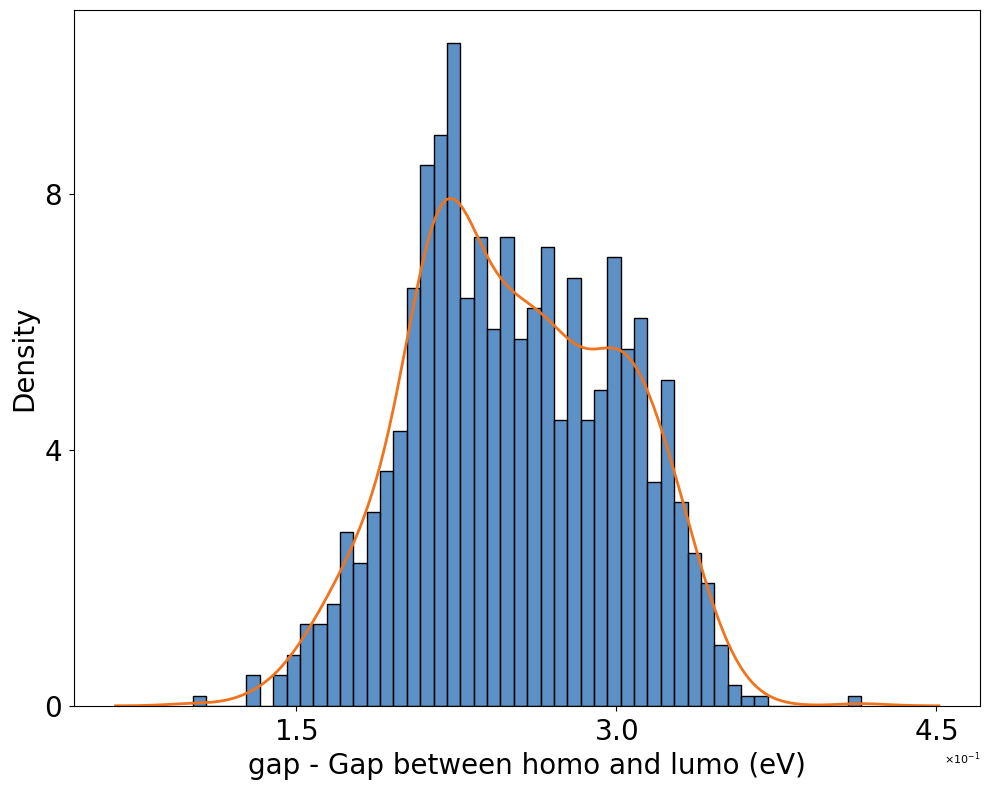

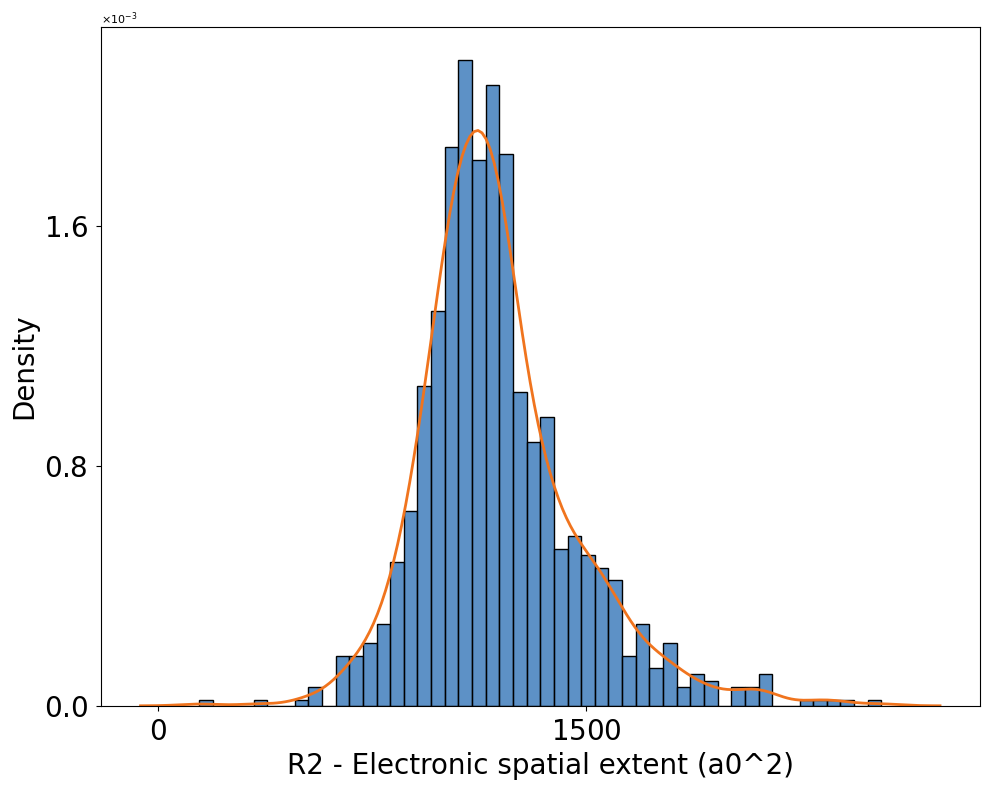

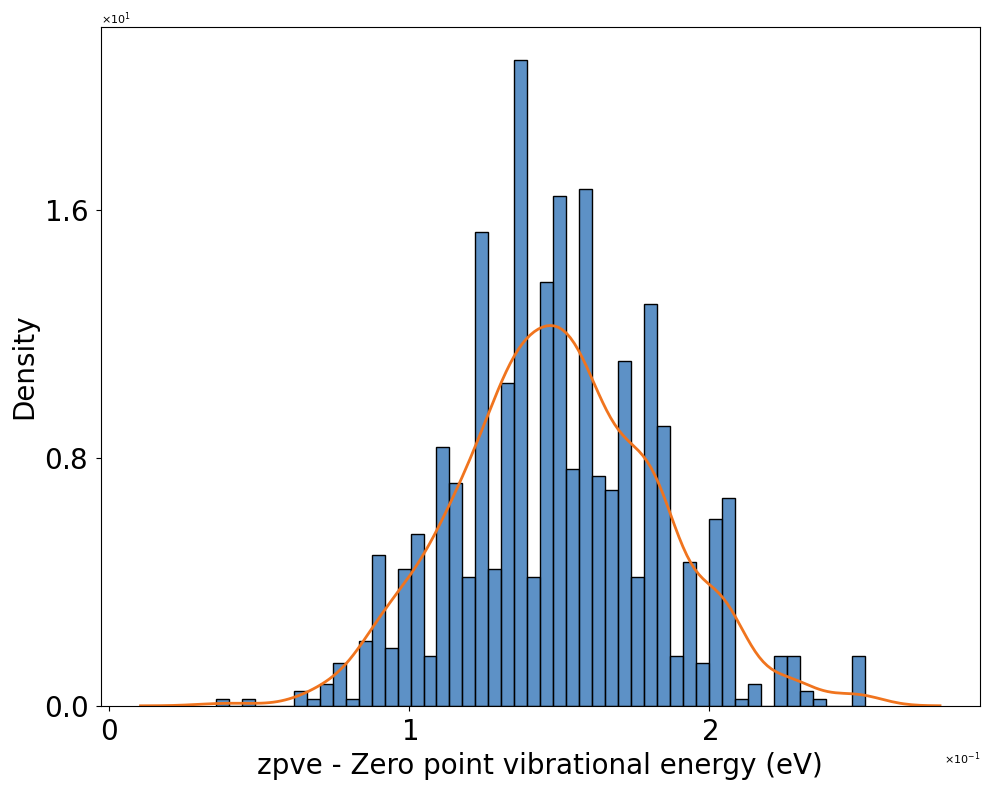

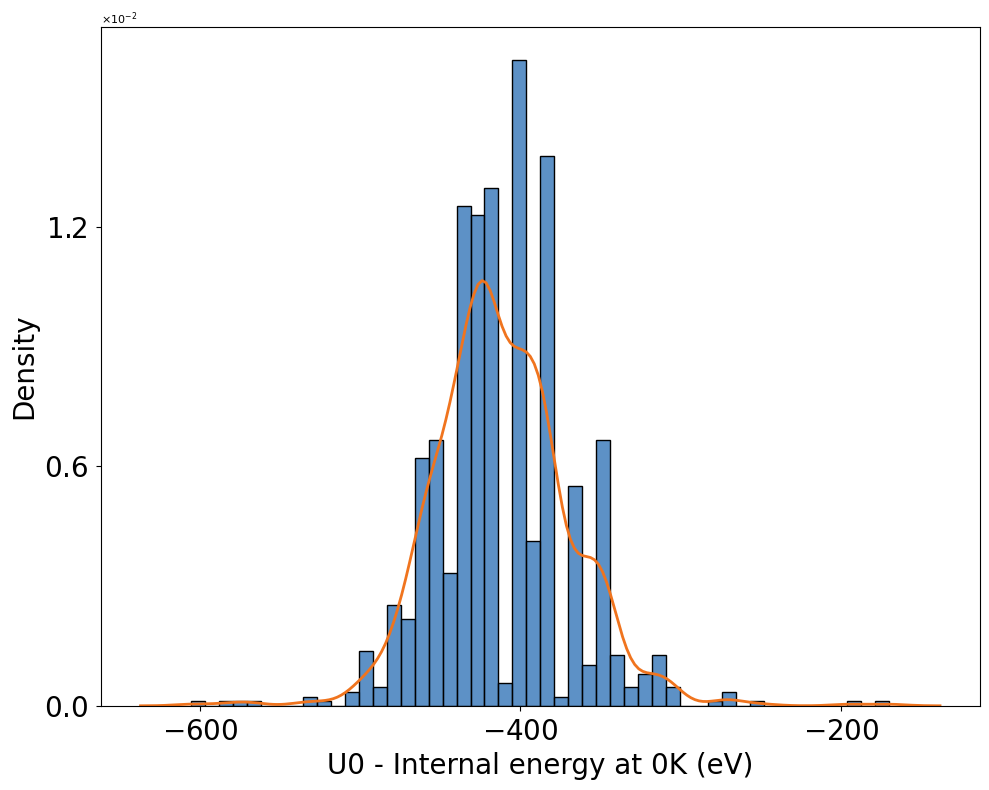

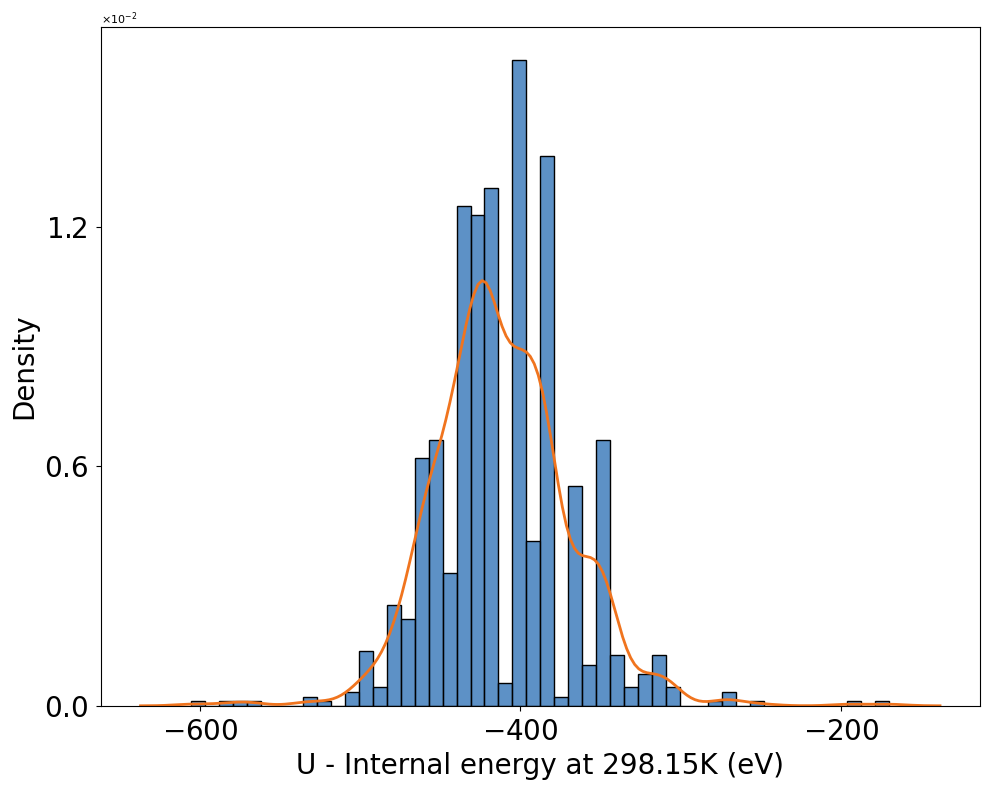

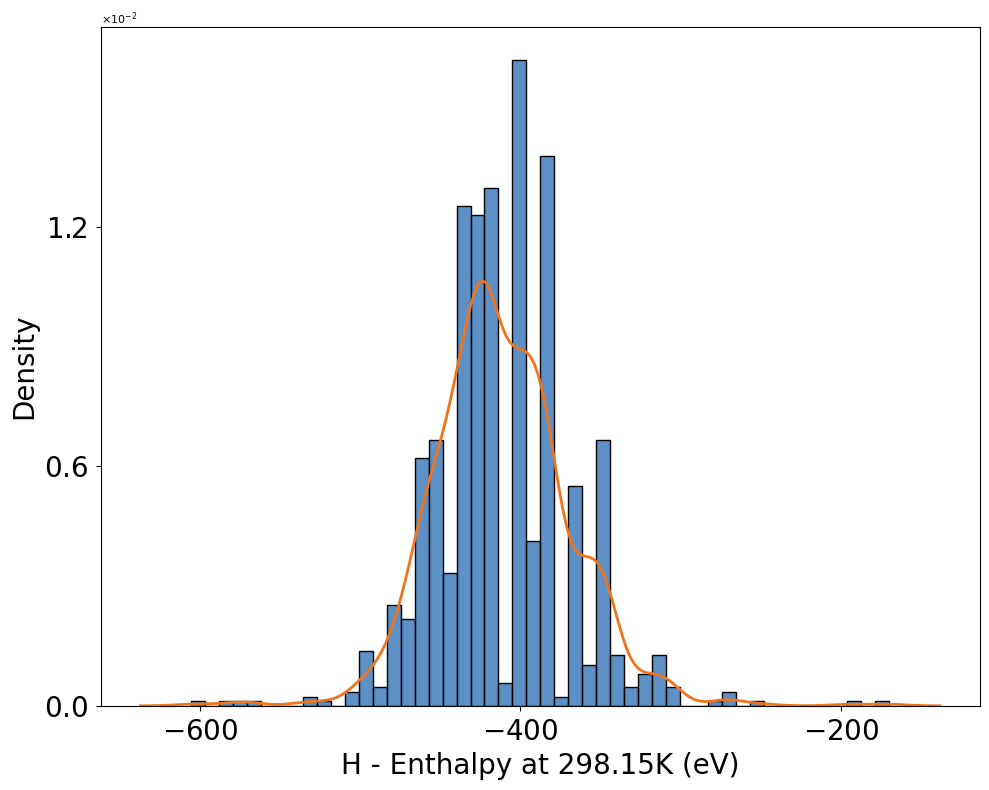

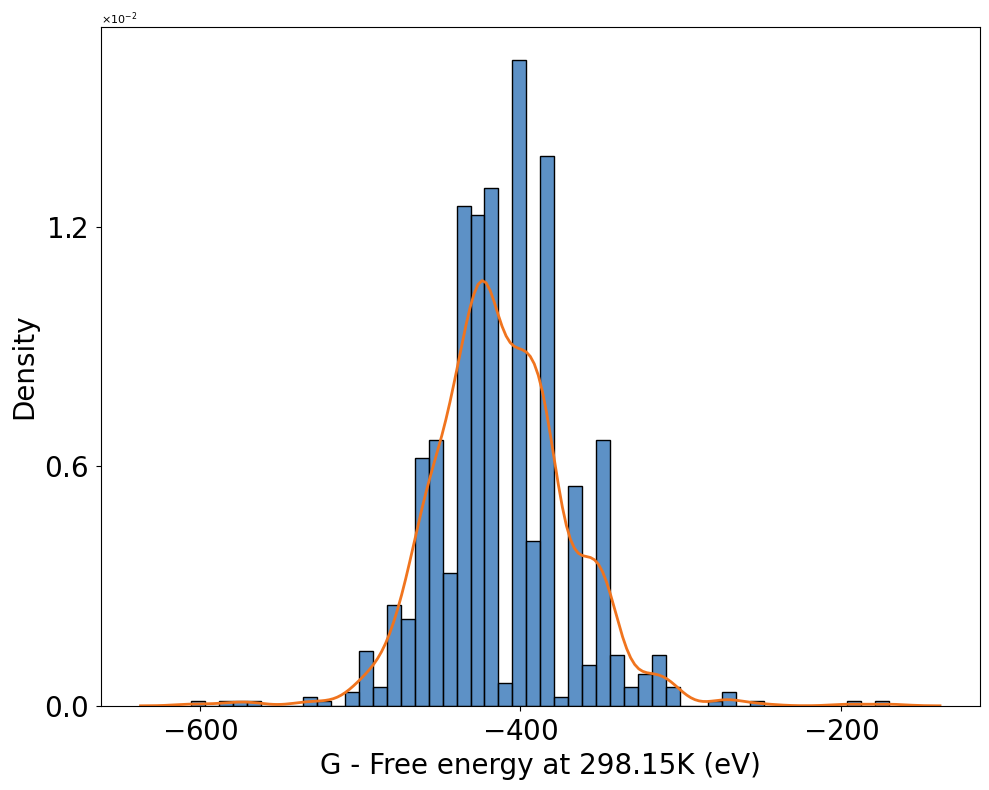

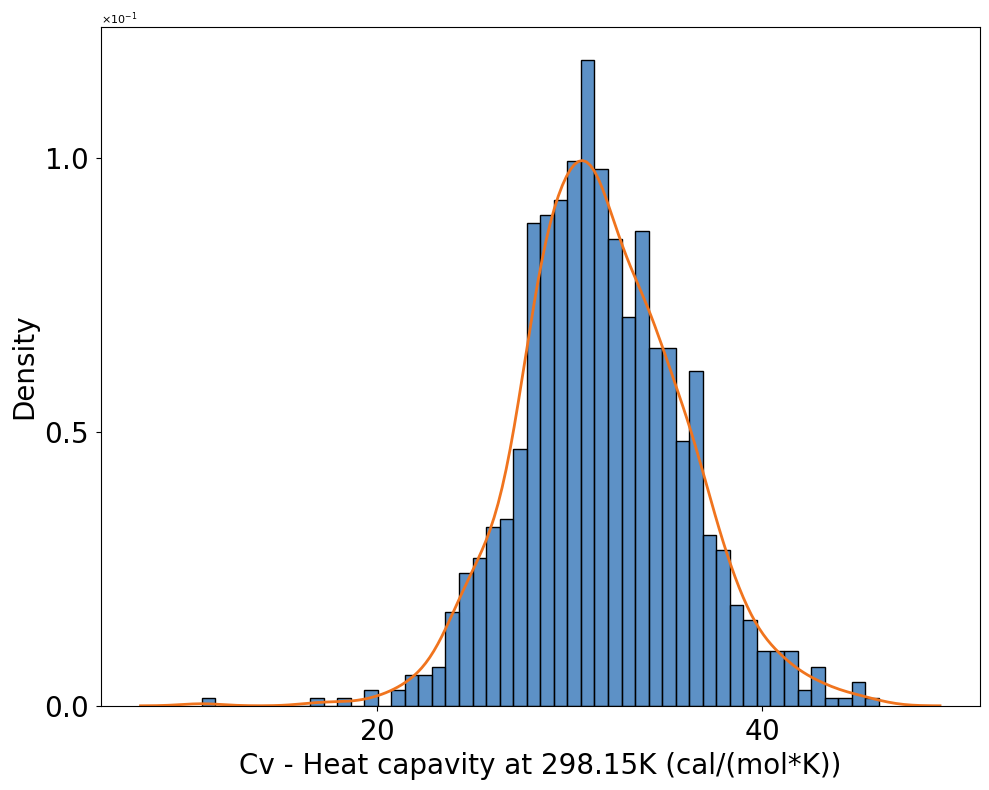

In [7]:
colors = ["#F0741E", "#276CB3"]
plt.style.use("seaborn-v0_8-paper")

target_list = ["A","B",	"C",	"mu",	"alpha",	"homo",	"lumo",	"gap",	"R2",	"zpve",	"U0",	"U",	"H",	"G",	"Cv"]
#dictionry of the x and y labels for plot
target_labels = {
    "A": ("A - Rotational constant (GHz)", "Density"),
    "B": ("B - Rotational constant (GHz)", "Density"),
    "C": (
        "C - Rotational constant (GHz)",
        "Density",
    ),
    "mu": (
        "mu - Dipole moment (D)",
        "Density",
    ),
    "alpha": (
        "alpha - Isotropic polarizability (a0^3)",
        "Density",
    ),
    "homo": (
        "homo - Highest orbital energy (eV)",
        "Density",
    ),
    "lumo": (
        "lumo - Lowest orbital energy (eV)",
        "Density",
    ),
    "gap": (
        "gap - Gap between homo and lumo (eV)",
        "Density",
    ),
    "R2": (
        "R2 - Electronic spatial extent (a0^2)",
        "Density",
    ),
    "zpve": (
        "zpve - Zero point vibrational energy (eV)",
        "Density",
    ),
    "U0": (
        "U0 - Internal energy at 0K (eV)",
        "Density",
    ),
    "U": (
        "U - Internal energy at 298.15K (eV)",
        "Density",
    ),
    "H": (
        "H - Enthalpy at 298.15K (eV)",
        "Density",
    ),
    "G": (
        "G - Free energy at 298.15K (eV)",
        "Density",
    ),
    "Cv": (
        "Cv - Heat capavity at 298.15K (cal/(mol*K))",
        "Density",
    ),
}

# histogram and the kde
for target in target_list:

    fig = plt.figure(figsize=(10, 8))

    ax = fig.add_subplot(1, 1, 1)

    sns.histplot(
        x=df_sorted[f"{target}"],
        fill=True,
        linewidth=1,
        kde=False,
        stat="density",
        color=colors[1],
        ax=ax,
        bins=50,
    )

    sns.kdeplot(x=df_sorted[f"{target}"], linewidth=2, color=colors[0], ax=ax)

    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1,1))
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)

    ax.xaxis.set_major_locator(MaxNLocator(nbins=3))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=3))
    ax.set_xlabel(target_labels[target][0], fontsize=20)
    ax.set_ylabel(target_labels[target][1], fontsize=20)
    plt.tick_params(axis="both", which="major", labelsize=20)
    plt.tight_layout()
    plt.show()


# Calculate and visualize Coulumb matrices

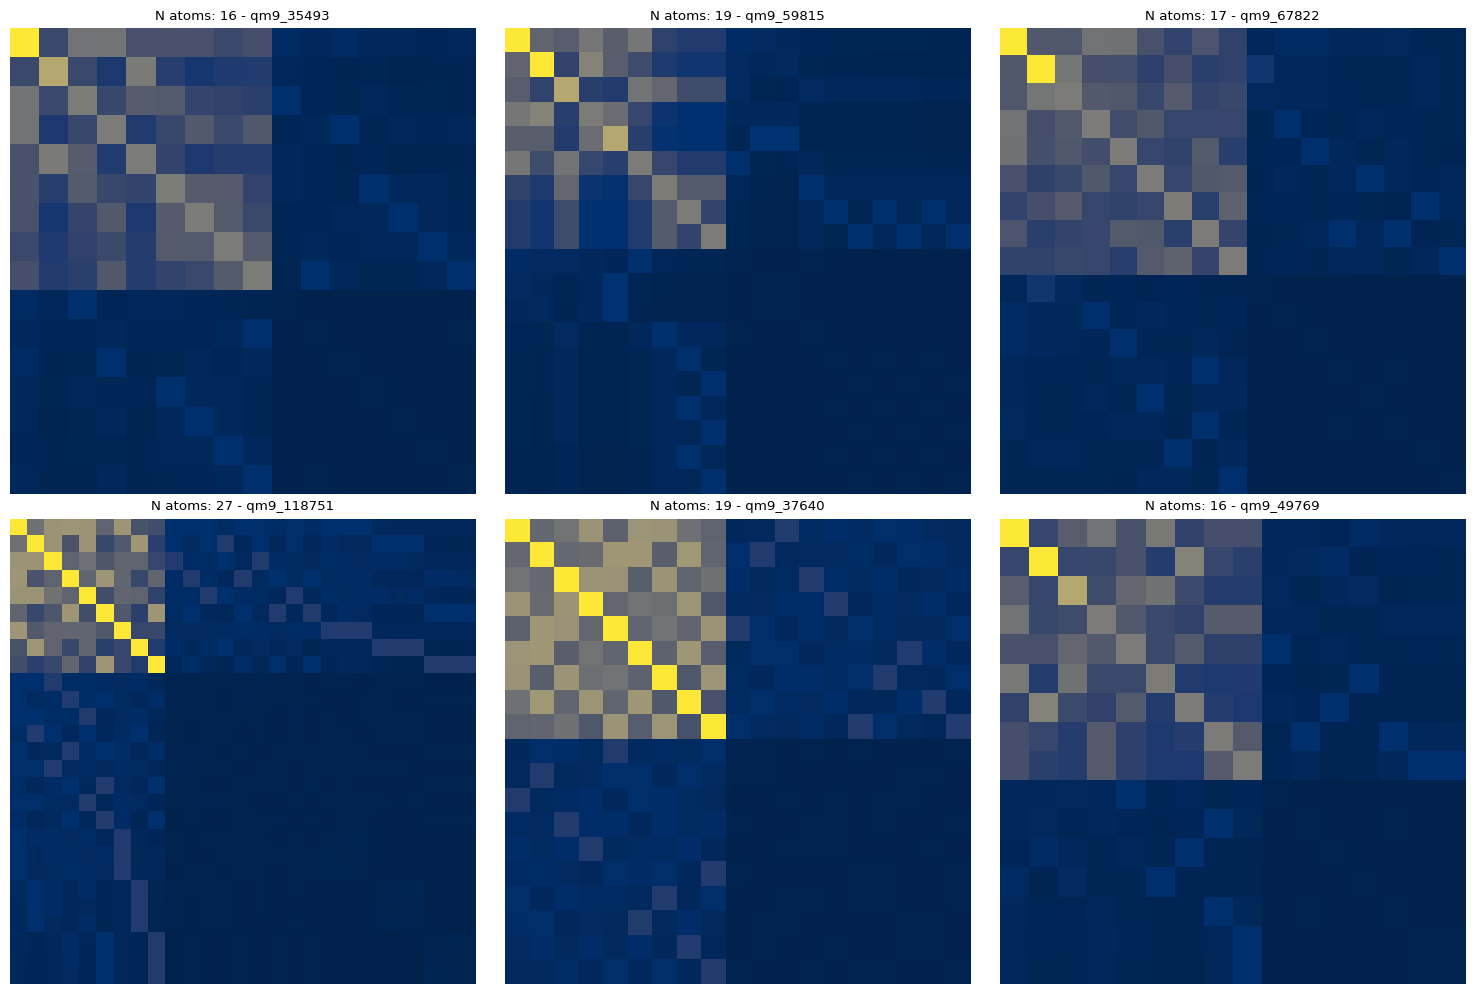

In [8]:
def display_random_images(data_path, n=6, num_cols=3):
    if not isinstance(num_cols, int):
        raise TypeError("ERROR: num_cols must be an integer")
    if not isinstance(n, int):
        raise TypeError("ERROR: n must be an integer")
    if num_cols <= 0:
        raise ValueError("ERROR: num_cols must be greater than zero")
    if n <= 0:
        raise ValueError("ERROR: n must be greater than zero")

    file_list = list(data_path.glob('*.xyz'))
    selected_files = random.sample(file_list, n)

    num_rows = (n + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5*num_cols,5*num_rows))

    axes = axes.flatten()

    for i, file_path in enumerate(selected_files):
        atomic_numbers, coordinates = read_xyz(file_path)
        c_mat = calculate_coulomb_matrix(atomic_numbers=atomic_numbers, coordinates=coordinates)
        c_mat = sort_by_row_norm(c_mat)
        image = c_mat

        axes[i].imshow(image, cmap="cividis")
        axes[i].set_title(f"N atoms: {len(atomic_numbers)} - {file_path.stem}" )
        axes[i].axis('off')

    for j in range(i + 1, num_rows * num_cols):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

display_random_images(data_path)

# Calculation and padding of eigenvalues

In [10]:
resolution = df_sorted["n_atoms"].max()
print("MAX ATOM NUMBER: ",resolution)
eig_list = []
data = {}
file_list = df_sorted["filename"].to_list()
for file_path in tqdm(file_list):

    atomic_numbers, coordinates = read_xyz(data_path.joinpath(file_path + ".xyz"))
    c_mat = calculate_coulomb_matrix(atomic_numbers=atomic_numbers, coordinates=coordinates)
    c_mat = sort_by_row_norm(c_mat)
    eig = compute_eigenvalues(matrix=c_mat)
    eig = eig.reshape(-1, 1)
    eig = padd_eig(matrix=eig, resolution=resolution)
    eig = normalize_min_max(matrix=eig)
    data[file_path] = eig

MAX ATOM NUMBER:  27


100%|██████████| 1000/1000 [00:00<00:00, 2908.62it/s]


In [12]:
data_list = []
for filename, eig_vector in data.items():
    row = {'filename': filename}
    for i, value in enumerate(eig_vector):
        row[f'eig_{i+1}'] = value[0]
    data_list.append(row)

df_eigenvalue = pd.DataFrame(data_list)

df_eigenvalue.head()

,filename,eig_1,eig_2,eig_3,eig_4,eig_5,eig_6,eig_7,eig_8,eig_9,...,eig_18,eig_19,eig_20,eig_21,eig_22,eig_23,eig_24,eig_25,eig_26,eig_27
0,qm9_12,1.0,0.318436,0.066977,0.000000,0.005441,0.007606,0.008217,0.008217,0.008217,...,0.008217,0.008217,0.008217,0.008217,0.008217,0.008217,0.008217,0.008217,0.008217,0.008217
1,qm9_162,1.0,0.243976,0.183058,0.104414,0.069680,0.000000,0.001067,0.003351,0.003718,...,0.007485,0.007485,0.007485,0.007485,0.007485,0.007485,0.007485,0.007485,0.007485,0.007485
2,qm9_325,1.0,0.405633,0.326911,0.101364,0.050412,0.015707,0.000000,0.003234,0.003234,...,0.003234,0.003234,0.003234,0.003234,0.003234,0.003234,0.003234,0.003234,0.003234,0.003234
3,qm9_402,1.0,0.329641,0.206722,0.122688,0.084379,0.028140,0.000000,0.001478,0.002069,...,0.006330,0.006330,0.006330,0.006330,0.006330,0.006330,0.006330,0.006330,0.006330,0.006330
4,qm9_574,1.0,0.448624,0.203155,0.113798,0.085831,0.036842,0.000000,0.000117,0.002006,...,0.006477,0.006477,0.006477,0.006477,0.006477,0.006477,0.006477,0.006477,0.006477,0.006477


In [13]:
target = "Cv" # can be one of ["A","B","C","mu","alpha","homo","lumo","gap","R2","zpve","U0","U","H","G","Cv"]

df_merged = pd.merge(df_eigenvalue, df_sorted[['filename', target]], on='filename', how='left')

df_merged.head(10)

,filename,eig_1,eig_2,eig_3,eig_4,eig_5,eig_6,eig_7,eig_8,eig_9,...,eig_19,eig_20,eig_21,eig_22,eig_23,eig_24,eig_25,eig_26,eig_27,Cv
0,qm9_12,1.0,0.318436,0.066977,0.000000,0.005441,0.007606,0.008217,0.008217,0.008217,...,0.008217,0.008217,0.008217,0.008217,0.008217,0.008217,0.008217,0.008217,0.008217,10.890
1,qm9_162,1.0,0.243976,0.183058,0.104414,0.069680,0.000000,0.001067,0.003351,0.003718,...,0.007485,0.007485,0.007485,0.007485,0.007485,0.007485,0.007485,0.007485,0.007485,16.868
2,qm9_325,1.0,0.405633,0.326911,0.101364,0.050412,0.015707,0.000000,0.003234,0.003234,...,0.003234,0.003234,0.003234,0.003234,0.003234,0.003234,0.003234,0.003234,0.003234,18.042
3,qm9_402,1.0,0.329641,0.206722,0.122688,0.084379,0.028140,0.000000,0.001478,0.002069,...,0.006330,0.006330,0.006330,0.006330,0.006330,0.006330,0.006330,0.006330,0.006330,22.957
4,qm9_574,1.0,0.448624,0.203155,0.113798,0.085831,0.036842,0.000000,0.000117,0.002006,...,0.006477,0.006477,0.006477,0.006477,0.006477,0.006477,0.006477,0.006477,0.006477,21.499
5,qm9_644,1.0,0.339178,0.127029,0.101072,0.146773,0.046315,0.000000,0.001791,0.003646,...,0.006287,0.006287,0.006287,0.006287,0.006287,0.006287,0.006287,0.006287,0.006287,20.831
6,qm9_655,1.0,0.310514,0.227941,0.095727,0.083522,0.040396,0.000000,0.001804,0.003092,...,0.006568,0.006568,0.006568,0.006568,0.006568,0.006568,0.006568,0.006568,0.006568,19.969
7,qm9_973,1.0,0.329041,0.250550,0.147406,0.105848,0.041615,0.024356,0.000000,0.000445,...,0.005488,0.005488,0.005488,0.005488,0.005488,0.005488,0.005488,0.005488,0.005488,25.999
8,qm9_1107,1.0,0.365473,0.200331,0.180522,0.143385,0.083203,0.039596,0.000000,0.000609,...,0.005199,0.005626,0.005626,0.005626,0.005626,0.005626,0.005626,0.005626,0.005626,34.301
9,qm9_1119,1.0,0.400276,0.224116,0.191134,0.157571,0.035419,0.021799,0.000000,0.000831,...,0.005188,0.005188,0.005188,0.005188,0.005188,0.005188,0.005188,0.005188,0.005188,26.151
